# Predicting an English Premier League Match Using EA Sports FIFA Rankings
### Nick Riley
### CMSC 320
## Introduction
The English Premier League (EPL) is the top tier league for European Football (Soccer) in England. It has 20 teams, and in a singular season from August to May, the teams play each other team once, one time at home, another away, tallying up to 38 matches per season per team. Most US sports have divisions and seperating leagues, where it all culminates to a playoff and an eventual championship match or series. Also, their records determine their standing as with most of these leagues there are no draws. This is different for the EPL and leagues alike as there are no divisions or playoffs/championships. A win is 3 points, a draw is 1 point, and a loss is 0 points. Each team plays their 38 matches, and after those, whoever has the most points wins. Besides number 1 being crowned champion, 20, 19, and 18 all get sent down into the second division for the next season, and 3 teams (one being the champion and the others going through a playoff) get promoted from the second division into the EPL. 

EA Sports FIFA, or just FIFA, is an annually released Sports Simulation video game released by Electronic Arts. Its first release came in the 1990s and has been releasing yearly since. It is the most popular and widely regarded as the most accurate soccer/footbal simulation game you can have. Besides the gameplay, one of the reasonings that FIFA has survived for so long is its exclusive rights from partnership with so many clubs and players around the world that you can play with. Its dominance has begun to wane as partnerships have fallen through, but it still has exclusive ownership of the most popular league and its players, the EPL. Every year, when the new FIFA is beginning to be announced, a large marketing tool is FIFA's rating system. Each player has nearly 30 numerical stats that influence their overall rating, each from 1 to 99. Then, a clubs overall rating comes from combining all of its players' ratings. While these ratings always come with discrepencies and controversy, from the surface, they do a decent job at predicting a teams rating in reference to other teams.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data/E0.csv')
data['Season'] = "21/22"
for i in range(1,16):
    d = pd.read_csv('data/E0 ('+str(i)+').csv')
    d['Season'] = ''+str(21-i)+'/'+str(22-i)
    data=data.append(d)
data

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,SJA,GBH,GBD,GBA,BSH,BSD,BSA,SBH,SBD,SBA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,14/08/2021,12:30,Man United,Leeds,5.0,1.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,14/08/2021,15:00,Burnley,Brighton,1.0,2.0,A,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3.0,0.0,H,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,14/08/2021,15:00,Everton,Southampton,3.0,1.0,H,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,13/05/07,NaN,Middlesbrough,Fulham,3.0,1.0,H,2.0,1.0,...,4.00,1.90,3.25,4.0,NaN,NaN,NaN,1.85,3.25,4.00
376,E0,13/05/07,NaN,Portsmouth,Arsenal,0.0,0.0,D,0.0,0.0,...,2.25,2.80,3.25,2.4,NaN,NaN,NaN,2.70,3.20,2.38
377,E0,13/05/07,NaN,Sheffield United,Wigan,1.0,2.0,A,1.0,2.0,...,3.00,2.25,3.50,2.9,NaN,NaN,NaN,2.20,3.20,3.00
378,E0,13/05/07,NaN,Tottenham,Man City,2.0,1.0,H,2.0,1.0,...,7.00,1.50,3.90,6.5,NaN,NaN,NaN,1.44,3.75,7.00


In [4]:
data = data[data['Date'].notna()]

In [5]:
had_data = data.groupby('Season')['FTR'].value_counts()

In [6]:
import requests
import re
import pandas as pd
import math
from datetime import datetime,timedelta
from bs4 import BeautifulSoup
fifa07 = requests.get("https://www.fifaindex.com/teams/fifa07_3/?league=13&order=desc")
fifa08 = requests.get("https://www.fifaindex.com/teams/fifa08_4/?league=13&order=desc")
fifa09 = requests.get("https://www.fifaindex.com/teams/fifa09_5/?league=13&order=desc")
fifa10 = requests.get("https://www.fifaindex.com/teams/fifa10_6/?league=13&order=desc")
fifa11 = requests.get("https://www.fifaindex.com/teams/fifa11_7/?league=13&order=desc")
fifa12 = requests.get("https://www.fifaindex.com/teams/fifa12_9/?league=13&order=desc")
fifa13 = requests.get("https://www.fifaindex.com/teams/fifa13_10/?league=13&order=desc")
fifa14 = requests.get("https://www.fifaindex.com/teams/fifa14_13/?league=13&order=desc")
fifa15 = requests.get("https://www.fifaindex.com/teams/fifa15_14/?league=13&order=desc")
fifa16 = requests.get("https://www.fifaindex.com/teams/fifa16_73/?league=13&order=desc")
fifa17 = requests.get("https://www.fifaindex.com/teams/fifa17_173/?league=13&order=desc")
fifa18 = requests.get("https://www.fifaindex.com/teams/fifa18_278/?league=13&order=desc")
fifa19 = requests.get("https://www.fifaindex.com/teams/fifa19_353/?league=13&order=desc")
fifa20 = requests.get("https://www.fifaindex.com/teams/fifa20_419/?league=13&order=desc")
fifa21 = requests.get("https://www.fifaindex.com/teams/fifa21_486/?league=13&order=desc")
fifa22 = requests.get("https://www.fifaindex.com/teams/?league=13&order=desc")

In [7]:
fifas = [fifa07,fifa08,fifa09,fifa10,fifa11,fifa12,fifa13,fifa14,\
         fifa15,fifa16,fifa17,fifa18,fifa19,fifa20,fifa21,fifa22]
lst = dict()
j = 7
for fifa in fifas:
    root = BeautifulSoup(fifa.content)
    tables = root.find("table")
    overalls = tables.findAll("td", {"data-title":"OVR"})
    teams = tables.findAll("a", text=re.compile("^(((([A-Z][a-z]+)|(&)|(AFC)|(F\.?C\.?)) ?)+)$"))
    teams = list(map(lambda x: re.search('>(((([A-Z][a-z]+)|(&amp;)|(AFC)|(F\.?C\.?)) ?)+)<',str(x))[1],teams))
    teams = [x for x in teams if 'Premier League' not in x]
    for i,team in enumerate(teams):
        if team == 'Manchester United':
            teams[i] = 'Man United'
        elif team == 'Manchester City':
            teams[i] = 'Man City'
        elif team == 'Wolverhampton Wanderers':
            teams[i] = 'Wolves'
        elif team == 'West Bromwich Albion' or team == 'West Bromwich':
            teams[i] = 'West Brom'
        elif team == 'Queens Park Rangers':
            teams[i] = 'QPR'
        elif team == 'Tottenham Hotspur':
            teams[i] = 'Tottenham'
        elif team == 'Cardiff City':
            teams[i] = 'Cardiff'
        elif team == 'Hull City':
            teams[i] = 'Hull'
        elif team == 'Newcastle United':
            teams[i] = 'Newcastle'
        elif team == 'Leicester City':
            teams[i] = 'Leicester'
        elif team == 'West Ham United':
            teams[i] = 'West Ham'
        elif team == 'Charlton Athletic':
            teams[i] = 'Charlton'
        elif team == 'Blackburn Rovers':
            teams[i] = 'Blackburn'
        elif team == 'Birmingham City':
            teams[i] = 'Birmingham'
        elif team == 'Huddersfield Town':
            teams[i] = 'Huddersfield'
        elif team == 'Swansea City':
            teams[i] = 'Swansea'
        elif team == 'Stoke City':
            teams[i] = 'Stoke'
        elif team == 'Norwich City':
            teams[i] = 'Norwich'
        elif team == 'Leeds United':
            teams[i] = 'Leeds'
        elif team == 'Brighton &amp; Hove Albion':
            teams[i] = 'Brighton'
        elif team == 'AFC Bournemouth':
            teams[i] = 'Bournemouth'
        elif team == 'Wigan Athletic':
            teams[i] = 'Wigan'
        elif team == 'Arsenal FC' or team == 'Arsenal F.C.':
            teams[i] = 'Arsenal'
        elif team == 'Bolton Wanderers':
            teams[i] = 'Bolton'
        elif team == 'Chelsea FC' or team == 'Chelsea F.C.':
            teams[i] = 'Chelsea'
        elif team == 'Reading FC' or team == 'Reading F.C.':
            teams[i] = 'Reading'
        elif team == 'Derby County':
            teams[i] = 'Derby'
        
            
            
        
    overalls = list(map(lambda x: re.search('>(\d\d)<',str(x))[1],overalls))
    t = dict()
    for i,team in enumerate(teams):
        t[team] = overalls[i]
    lst[str(j-1)+'/'+str(j)] = t
    j += 1
lst

{'6/7': {'Chelsea': '84',
  'Man United': '82',
  'Arsenal': '82',
  'Liverpool': '81',
  'Newcastle': '79',
  'Tottenham': '79',
  'Everton': '77',
  'Blackburn': '77',
  'Man City': '77',
  'Middlesbrough': '76',
  'West Ham': '76',
  'Bolton': '76',
  'Charlton': '75',
  'Aston Villa': '75',
  'Fulham': '75',
  'Portsmouth': '75',
  'Wigan': '74',
  'Sheffield United': '72',
  'Reading': '71',
  'Watford': '68'},
 '7/8': {'Man United': '83',
  'Chelsea': '83',
  'Liverpool': '81',
  'Arsenal': '80',
  'Tottenham': '78',
  'Newcastle': '77',
  'Blackburn': '76',
  'Everton': '76',
  'Portsmouth': '76',
  'West Ham': '76',
  'Middlesbrough': '75',
  'Man City': '75',
  'Aston Villa': '75',
  'Bolton': '75',
  'Reading': '74',
  'Fulham': '74',
  'Birmingham': '72',
  'Wigan': '72',
  'Sunderland': '71',
  'Derby': '69'},
 '8/9': {'Chelsea': '84',
  'Man United': '84',
  'Arsenal': '81',
  'Liverpool': '81',
  'Man City': '79',
  'Tottenham': '79',
  'Everton': '78',
  'Aston Villa': '

In [8]:
data.reset_index(inplace=True)
df = data.loc[:, data.columns.intersection(['Date','Season','HomeTeam', 'AwayTeam','FTR','FTHG','FTAG','HTR','HTHG','HTAG'])]
df['HomeOVR'] = 0
df['AwayOVR'] = 0
for i,row in df.iterrows():
    
    # 2 teams have issues on the fifaindex website
    # 11/12 Arsenal when they are in the pro league: 81 overall
    # 12/13 South Hampton when they are in the MLS: 73 overall
    # we will just manualy grab them
    season = row['Season']
    home = row['HomeTeam']
    away = row['AwayTeam']
    try:
        df.at[i,'HomeOVR'] = lst[season][home]
        try:
            df.at[i,'AwayOVR'] = lst[season][away]
        except:
            if away == 'Arsenal':
                df.at[i,'AwayOVR'] = 81
            if away == 'Southampton':
                df.at[i,'AwayOVR'] = 73
    except:
        if home == 'Arsenal':
                df.at[i,'HomeOVR'] = 81
        if home == 'Southampton':
            df.at[i,'HomeOVR'] = 73
        
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,HomeOVR,AwayOVR
0,13/08/2021,Brentford,Arsenal,2.0,0.0,H,1.0,0.0,H,21/22,74,80
1,14/08/2021,Man United,Leeds,5.0,1.0,H,1.0,0.0,H,21/22,83,76
2,14/08/2021,Burnley,Brighton,1.0,2.0,A,1.0,0.0,H,21/22,76,76
3,14/08/2021,Chelsea,Crystal Palace,3.0,0.0,H,2.0,0.0,H,21/22,84,76
4,14/08/2021,Everton,Southampton,3.0,1.0,H,0.0,1.0,A,21/22,78,76
...,...,...,...,...,...,...,...,...,...,...,...,...
6026,13/05/07,Middlesbrough,Fulham,3.0,1.0,H,2.0,1.0,H,6/7,76,75
6027,13/05/07,Portsmouth,Arsenal,0.0,0.0,D,0.0,0.0,D,6/7,75,82
6028,13/05/07,Sheffield United,Wigan,1.0,2.0,A,1.0,2.0,A,6/7,72,74
6029,13/05/07,Tottenham,Man City,2.0,1.0,H,2.0,1.0,H,6/7,79,77


In [9]:
df['Difference'] = 0
for i,row in df.iterrows():
    if row['FTR'] == 'H':
        df.at[i,'Difference'] = row['HomeOVR'] - row['AwayOVR']
    elif row['FTR'] == 'A':
        df.at[i,'Difference'] = row['AwayOVR'] - row['HomeOVR']
    else:
        df.at[i,'Difference'] = abs(row['AwayOVR'] - row['HomeOVR'])
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season,HomeOVR,AwayOVR,Difference
0,13/08/2021,Brentford,Arsenal,2.0,0.0,H,1.0,0.0,H,21/22,74,80,-6
1,14/08/2021,Man United,Leeds,5.0,1.0,H,1.0,0.0,H,21/22,83,76,7
2,14/08/2021,Burnley,Brighton,1.0,2.0,A,1.0,0.0,H,21/22,76,76,0
3,14/08/2021,Chelsea,Crystal Palace,3.0,0.0,H,2.0,0.0,H,21/22,84,76,8
4,14/08/2021,Everton,Southampton,3.0,1.0,H,0.0,1.0,A,21/22,78,76,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,13/05/07,Middlesbrough,Fulham,3.0,1.0,H,2.0,1.0,H,6/7,76,75,1
6027,13/05/07,Portsmouth,Arsenal,0.0,0.0,D,0.0,0.0,D,6/7,75,82,7
6028,13/05/07,Sheffield United,Wigan,1.0,2.0,A,1.0,2.0,A,6/7,72,74,2
6029,13/05/07,Tottenham,Man City,2.0,1.0,H,2.0,1.0,H,6/7,79,77,2


In [10]:
seasons = np.flip(df['Season'].unique())
by_season = dict()
for i,e in enumerate(seasons):
    season = df.loc[df['Season'] == e]
    by_season[e] = {'H':(season.loc[season.FTR == 'H','FTR'].count(),
                         season.loc[season.FTR == 'H','Difference'].mean(),
                         season.loc[season.FTR == 'H','Difference'].abs().mean()),
                   'A':(season.loc[season.FTR == 'A','FTR'].count(),
                        season.loc[season.FTR == 'A','Difference'].mean(),
                        season.loc[season.FTR == 'A','Difference'].abs().mean()),
                   'D':(season.loc[season.FTR == 'D','FTR'].count(),
                        season.loc[season.FTR == 'D','Difference'].mean(),
                        season.loc[season.FTR == 'D','Difference'].abs().mean())}
by_season

{'6/7': {'H': (182, 1.7032967032967032, 4.483516483516484),
  'A': (100, 2.97, 4.69),
  'D': (98, 4.010204081632653, 4.010204081632653)},
 '7/8': {'H': (176, 2.471590909090909, 4.232954545454546),
  'A': (104, 3.8846153846153846, 4.653846153846154),
  'D': (100, 3.63, 3.63)},
 '8/9': {'H': (173, 2.1734104046242773, 4.855491329479769),
  'A': (110, 3.6363636363636362, 5.0),
  'D': (97, 3.8969072164948453, 3.8969072164948453)},
 '9/10': {'H': (193, 2.2072538860103625, 4.300518134715026),
  'A': (91, 3.21978021978022, 4.362637362637362),
  'D': (96, 3.71875, 3.71875)},
 '10/11': {'H': (179, 1.7150837988826815, 4.284916201117318),
  'A': (90, 2.433333333333333, 4.9),
  'D': (111, 3.90990990990991, 3.90990990990991)},
 '11/12': {'H': (171, 7.304093567251462, 9.771929824561404),
  'A': (116, 0.5172413793103449, 6.379310344827586),
  'D': (93, 6.720430107526882, 6.720430107526882)},
 '12/13': {'H': (166, 4.981927710843373, 6.427710843373494),
  'A': (106, -1.9150943396226414, 7.83962264150943

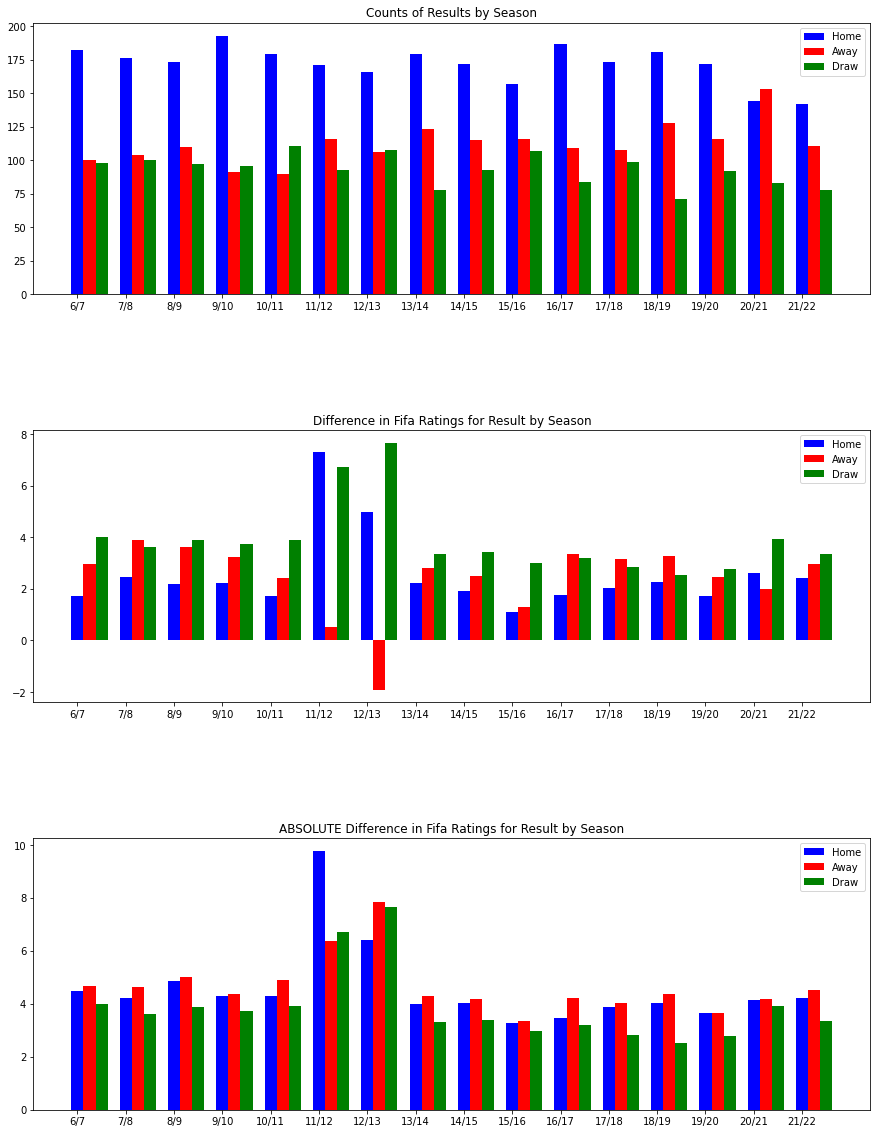

In [11]:
home_count = [by_season[x]['H'][0] for x in by_season]
home_diff = [by_season[x]['H'][1] for x in by_season]
home_abs_diff = [by_season[x]['H'][2] for x in by_season]

away_count = [by_season[x]['A'][0] for x in by_season]
away_diff = [by_season[x]['A'][1] for x in by_season]
away_abs_diff = [by_season[x]['A'][2] for x in by_season]

draw_count = [by_season[x]['D'][0] for x in by_season]
draw_diff = [by_season[x]['D'][1] for x in by_season]
draw_abs_diff = [by_season[x]['D'][2] for x in by_season]
X = np.arange(16)
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize = (15,20))
ax1.set_title('Counts of Results by Season')
ax1.bar(seasons,home_count,color='b',width = 0.25)
ax1.bar(X+.25,away_count,color='r',width = 0.25)
ax1.bar(X+.5,draw_count,color='g',width = 0.25)
ax1.legend(['Home','Away','Draw'])

ax2.set_title('Difference in Fifa Ratings for Result by Season')
ax2.bar(seasons,home_diff,color='b',width = 0.25)
ax2.bar(X+.25,away_diff,color='r',width = 0.25)
ax2.bar(X+.5,draw_diff,color='g',width = 0.25)
ax2.legend(['Home','Away','Draw'])

ax3.set_title('ABSOLUTE Difference in Fifa Ratings for Result by Season')
ax3.bar(seasons,home_abs_diff,color='b',width = 0.25)
ax3.bar(X+.25,away_abs_diff,color='r',width = 0.25)
ax3.bar(X+.5,draw_abs_diff,color='g',width = 0.25)
ax3.legend(['Home','Away','Draw'])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
plt.show()